## Simulate White/Pink/Brown Noise MFDFA

White noise = $\frac{1}{f^{0}}$ 

Pink noise = $\frac{1}{f^{1}}$ 

Brownian noise = $\frac{1}{f^{2}}$

### Get 20 samples of each noise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorednoise as cn

In [2]:
colors = []
sigs = []

## for every color
for beta, color in zip([0, 1, 2], ['white', 'pink', 'brown']):
    ## generate 100
    for n in np.arange(0, 100):
        samples = 1200 # number of samples to generate
        sigs.append(cn.powerlaw_psd_gaussian(beta, samples))
        colors.append(color)

In [3]:
noises = pd.DataFrame(
    {
        'colors' : colors,
        'sigs' : sigs
    }
)

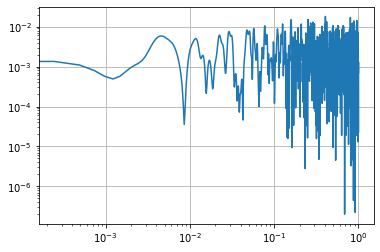

In [4]:
# optionally plot the Power Spectral Density with Matplotlib
from matplotlib import mlab
from matplotlib import pylab as plt

y = noises[noises['colors'] == 'white'].sigs.values[0]

s, f = mlab.psd(y, NFFT=2**13)
plt.loglog(f,s)
plt.grid(True)
plt.show()

## Apply MFDFA on noise simulations

In [5]:
import numpy as np
from starling_rhythm.mfdfa import hurst_expo
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm

/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
n_jobs = 36 ## set up joblib parameters
verbose = 0

In [7]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    h_expos = parallel(
        delayed(hurst_expo)(
            amp_env
        ) 
        for amp_env in tqdm(noises.sigs.values, desc = "Retrieving Hurst Exponents for All Noises.")
    )

Retrieving Hurst Exponents for All Noises.: 100%|██████████| 300/300 [00:05<00:00, 59.86it/s]


In [8]:
## Get MF_range
MF_range = []
for h_expo in h_expos:
    MF_range.append(max(h_expo) - min(h_expo))

In [9]:
noises['h_expo'] = h_expos
noises['MF_range'] = MF_range

In [10]:
noises.head()

,colors,sigs,h_expo,MF_range
0,white,"[-0.5373605258928552, -0.9799420410175543, -1....","[0.5204364735875585, 0.5111383395724249, 0.503...",0.048576
1,white,"[0.10851029568047643, 0.4946327686974014, 0.67...","[0.5246861887546073, 0.5129321169369345, 0.502...",0.067717
2,white,"[-0.26220269505963817, -0.14871775871339463, -...","[0.47533766468125765, 0.46484689581235783, 0.4...",0.064625
3,white,"[0.35753717522649814, -2.3011304721857395, -0....","[0.5181473352523792, 0.5119971582787107, 0.507...",0.035288
4,white,"[-0.5211289593869027, 1.0507671233059332, -0.0...","[0.5003367694515549, 0.4901754094611612, 0.481...",0.058870


## Produce IAAFT surrogates

In [11]:
import starling_rhythm.iaaft as iaaft
from starling_rhythm.mfdfa import hurst_expo
from joblib import Parallel, delayed
from timeit import timeit
from tqdm.autonotebook import tqdm

In [12]:
def SDoMF_iaaft(amp_env, ns = 32):
    '''
    For each amplitude envelope, find some number of its surrogates, and find MF_range for all surrogates
    '''
    
    ## calculate its surrogates
    surrogates = iaaft.surrogates(amp_env, ns = ns, maxiter = 10000, verbose = True)
    
    ## container for SDoMF_iaaft
    SDoMF = []
    
    ## find all the Hurst exponents of all the surrogates
    for surrogate in surrogates:
        ## Output Hs for each surrogate
        h_expos = hurst_expo(surrogate)
        SDoMF.append(max(h_expos) - min(h_expos))
            
    return SDoMF

In [13]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    mf_ranges = parallel(
        delayed(SDoMF_iaaft)(
            amp_env
        )
        for amp_env in tqdm(noises.sigs.values, desc = 'Running Surrogate Data')
    )

Running Surrogate Data: 100%|██████████| 300/300 [01:25<00:00,  3.49it/s]


In [14]:
noises['mf_iaaft_range'] = mf_ranges

## Parse t-statistics

In [15]:
import scipy.stats as stats
import numpy as np

In [16]:
ts = []
p = []
for MF_range, mf_iaaft_range in zip(noises['MF_range'].values, noises['mf_iaaft_range']):
    test = stats.ttest_1samp(mf_iaaft_range, MF_range)
    ts.append(test[0])
    p.append(test[1])
    
noises['ts'] = ts
noises['p'] = p

In [17]:
import statsmodels.stats.multitest

In [18]:
bonferroni = statsmodels.stats.multitest.multipletests(noises['p'].values, alpha = 0.05, method = 'bonferroni')
noises['sig'] = bonferroni[0]
noises['bonf_p'] = bonferroni[1]

In [19]:
noises.head()

,colors,sigs,h_expo,MF_range,mf_iaaft_range,ts,p,sig,bonf_p
0,white,"[-0.5373605258928552, -0.9799420410175543, -1....","[0.5204364735875585, 0.5111383395724249, 0.503...",0.048576,"[0.052883395226997754, 0.07012835751097646, 0....",8.704687,7.889311e-10,True,2.366793e-07
1,white,"[0.10851029568047643, 0.4946327686974014, 0.67...","[0.5246861887546073, 0.5129321169369345, 0.502...",0.067717,"[0.05428932344597753, 0.06832403925984532, 0.0...",-8.221284,2.758109e-09,True,8.274327e-07
2,white,"[-0.26220269505963817, -0.14871775871339463, -...","[0.47533766468125765, 0.46484689581235783, 0.4...",0.064625,"[0.06371773241099432, 0.052263766880298435, 0....",-2.980563,5.555470e-03,False,1.000000e+00
3,white,"[0.35753717522649814, -2.3011304721857395, -0....","[0.5181473352523792, 0.5119971582787107, 0.507...",0.035288,"[0.056547928440547346, 0.04454765652971221, 0....",7.723128,1.033203e-08,True,3.099609e-06
4,white,"[-0.5211289593869027, 1.0507671233059332, -0.0...","[0.5003367694515549, 0.4901754094611612, 0.481...",0.058870,"[0.06154940381582863, 0.06492346721101139, 0.0...",0.919274,3.650503e-01,False,1.000000e+00


In [29]:
from scipy.signal import hilbert

In [33]:
np.abs(hilbert([np.zeros(100)]))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [27]:
noises[noises['colors'] == 'brown']

,colors,sigs,h_expo,MF_range,mf_iaaft_range,ts,p,sig,bonf_p
200,brown,"[-0.40319356366052195, -0.47304860404471405, -...","[1.550274292463101, 1.5375801521588581, 1.5263...",0.078332,"[0.1183010369220765, 0.18588048021872638, 0.20...",16.484732,6.825078e-17,True,2.047523e-14
201,brown,"[-2.3350023120157912, -2.5179961786689904, -2....","[1.5592346978703648, 1.5384022156884016, 1.520...",0.122732,"[0.12812377815887865, 0.2739935620098104, 0.17...",6.190442,7.145301e-07,True,2.143590e-04
202,brown,"[-1.5590920742029988, -1.6014298036380545, -1....","[1.5528716799579474, 1.539717947013287, 1.5288...",0.075368,"[0.2172622826460895, 0.16756173111833172, 0.22...",20.774000,9.394963e-20,True,2.818489e-17
203,brown,"[0.28878177213452116, 0.11330634997014859, 0.1...","[1.5070656763877228, 1.4934498831418248, 1.482...",0.076572,"[0.1366900877598598, 0.14540109777291454, 0.13...",13.446336,1.774266e-14,True,5.322799e-12
204,brown,"[-0.17712412283340762, -0.15516725997413056, -...","[1.4911732007794454, 1.4781561592236547, 1.466...",0.080976,"[0.06974160160781429, 0.17420952577968007, 0.1...",8.385096,1.798662e-09,True,5.395986e-07
...,...,...,...,...,...,...,...,...,...
295,brown,"[0.049882773228756415, 0.14096350208875433, 0....","[1.5531921792575154, 1.5323504909974028, 1.513...",0.123998,"[0.1646159097208466, 0.14778383111279259, 0.13...",4.894140,2.908506e-05,True,8.725519e-03
296,brown,"[0.4241645959834952, 0.4494442571014997, 0.324...","[1.4333549041895688, 1.427288520604722, 1.4225...",0.048326,"[0.1880279325483849, 0.1739377093034351, 0.108...",16.555005,6.060437e-17,True,1.818131e-14
297,brown,"[-1.6136165438221304, -1.7471750465119074, -1....","[1.4541209029144992, 1.4389129836387886, 1.425...",0.087976,"[0.1448485980515155, 0.14231614022893058, 0.17...",12.882450,5.506181e-14,True,1.651854e-11
298,brown,"[0.05848769312981011, 0.15954599411435216, 0.1...","[1.4943903648689298, 1.479999853177002, 1.4674...",0.084494,"[0.16612463114820963, 0.08600997973848545, 0.1...",13.332715,2.222943e-14,True,6.668830e-12


In [20]:
### Out of all noises, how many are significantly multifractal?
np.unique(noises[noises['colors'] == 'white']['sig'].values, return_counts = True) 

(array([False,  True]), array([53, 47]))

<AxesSubplot:xlabel='ts', ylabel='Density'>

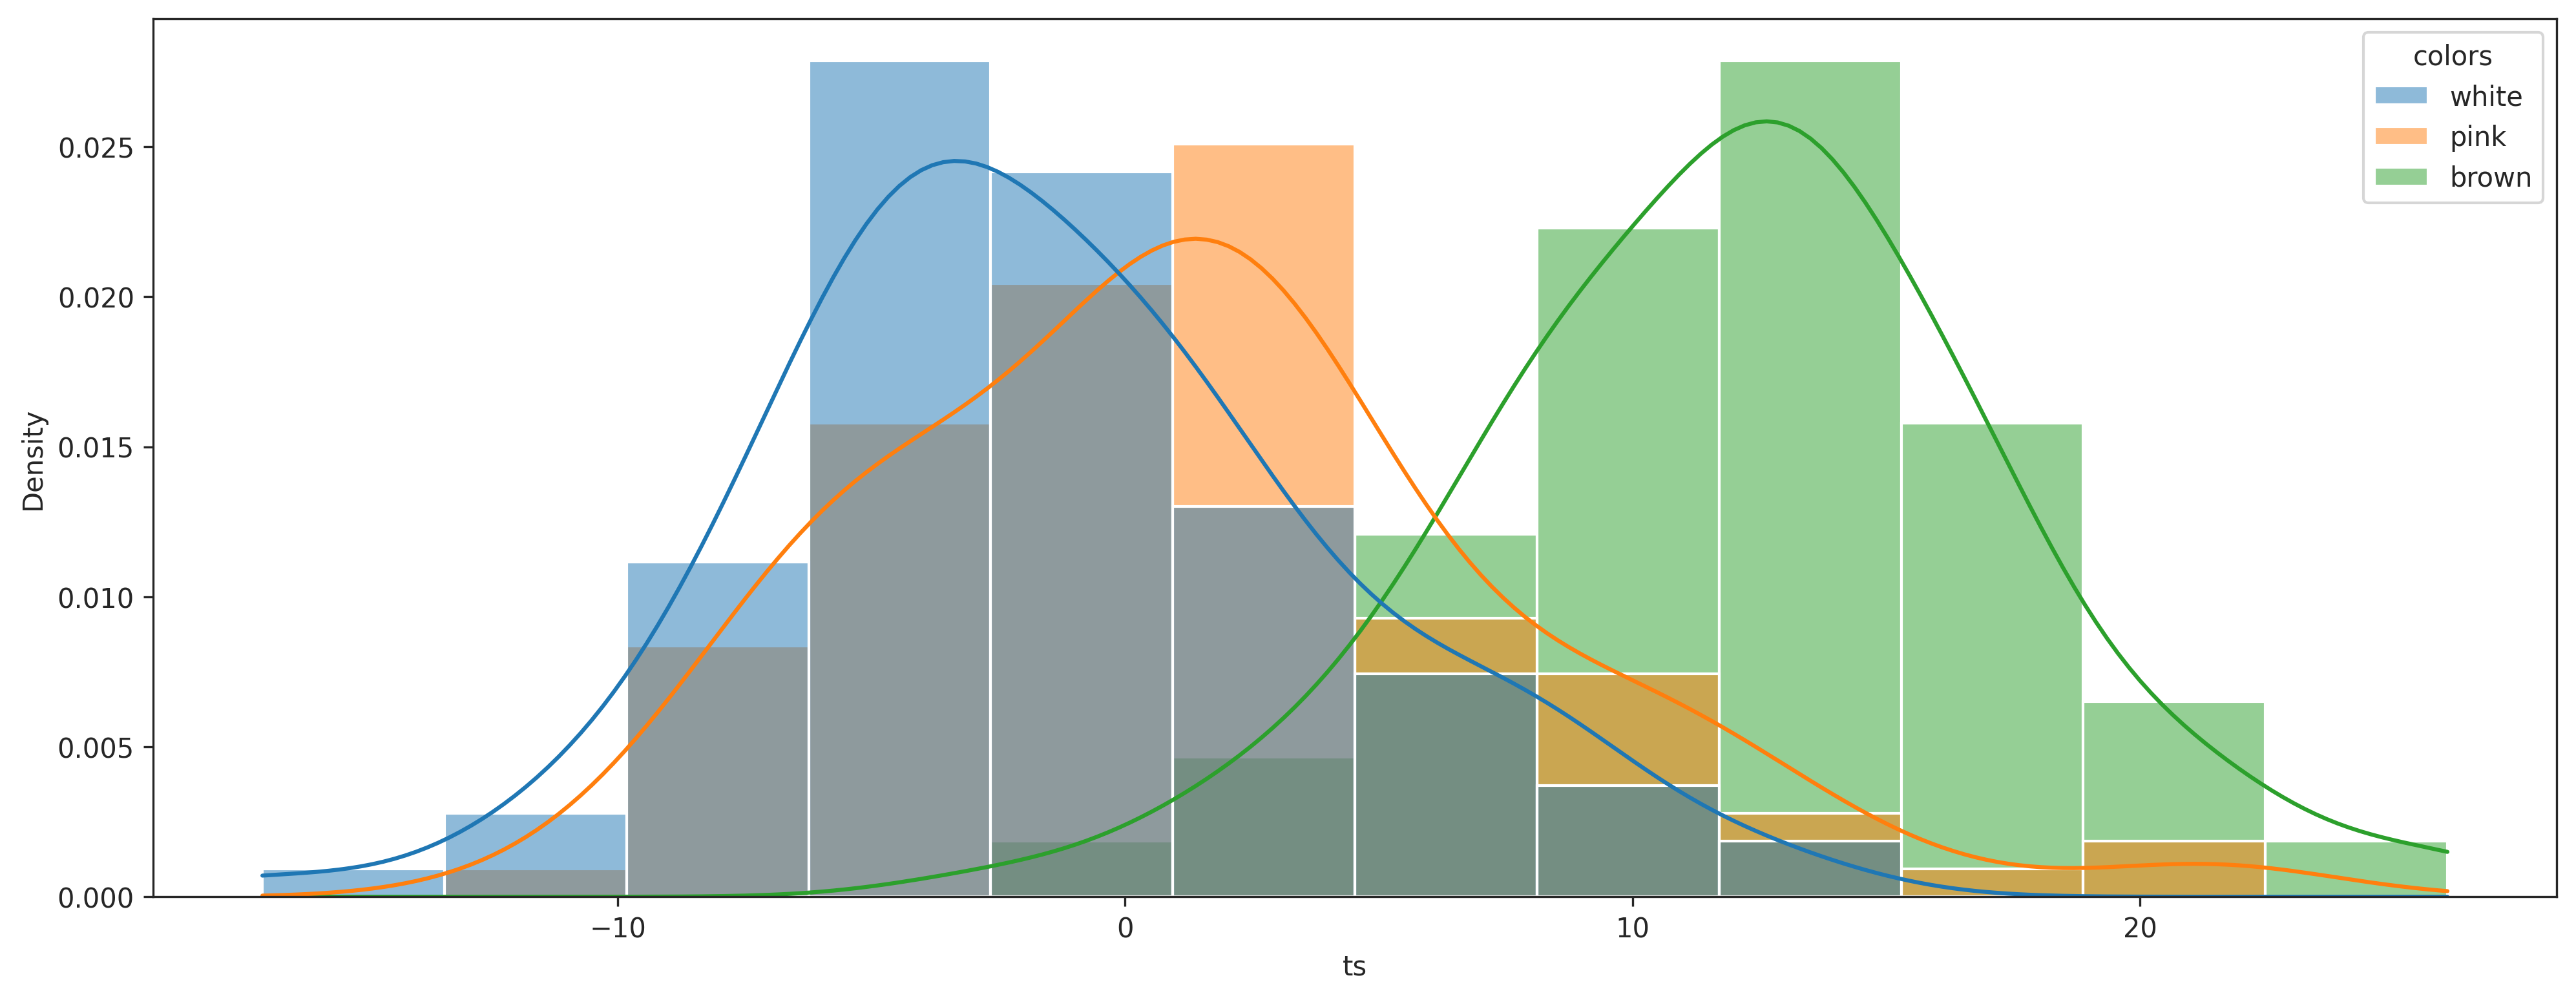

In [21]:
### distribution?
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams['patch.edgecolor'] = 'none'
figure(figsize = (16, 6), dpi = 300)
sns.set_style('ticks')

sns.histplot(data = noises, x = 'ts', stat = 'density', color = 'black', hue = 'colors', kde = True)